# Nebulosas ionizadas

## Estudio de la población relativa de los niveles de OIII en una nebulosa ionizada

**Estudiar la población relativa de los cinco niveles inferiores del ion OIII (O++) en
una nebulosa ionizada con distintos valores de las condiciones físicas. Usar el
paquete de análisis de líneas de emisión PyNeb con los datos atómicos del ion que
usa por defecto.**

Empezamos con algunos imports:

In [1]:
# Imports:
from astropy.io import fits
from astropy.table import QTable
from astropy import units as u
from astropy.constants import c, h, k_B
import matplotlib.pyplot as plt
from matplotlib.scale import AsinhScale
import numpy as np
import os, glob
import shutil
import matplotlib

import pyneb as pn

# Rendering con LaTEX:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')  # Use a serif font for LaTeX rendering
plt.rc('font', size=16)  # Adjust size to your preference
# Define the LaTeX preamble with siunitx
plt.rcParams['text.latex.preamble'] = r'''
            \usepackage{siunitx}
            \sisetup{
              detect-family,
              separate-uncertainty=true,
              output-decimal-marker={.},
              exponent-product=\cdot,
              inter-unit-product=\cdot,
            }
            \DeclareSIUnit{\cts}{cts}
            \DeclareSIUnit{\dyn}{dyn}
            \DeclareSIUnit{\mag}{mag}
            \usepackage{sansmath}  % Allows sans-serif in math mode
            '''
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "mathptmx",
})

import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "mathptmx",
})


Directorio donde guardaremos las figuras:


In [2]:
# Directorio con las figuras que se van a generar:
results_dir = "Figuras"
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir)

### Apartado a)

**Obtener el diagrama de Grotrian del ion OIII (indicando solo las transiciones más brillantes, usando thresh_int=1e-2) así como las densidades críticas de los distintos niveles suponiendo una temperatura electrónica de 10000K.**

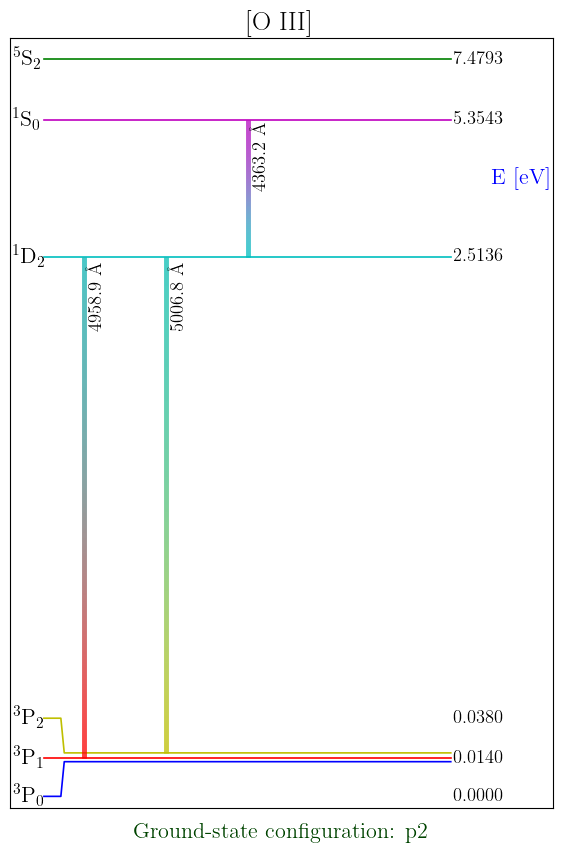

In [3]:
# Definimos el ion OIII (O++)
O3 = pn.Atom('O', 3)

# Dibujamos el diagrama de Grotrian (con solo las transiciones más brillantes que 1e-2) suponiendo una densidad en la nebulosa de 500 cm^-3
fig, ax = plt.subplots(figsize=(7, 10))
O3.plotGrotrian(thresh_int=1e-2, tem=1e4, den=1e6, ax=ax)
ax.set_ylim(-0.2,8.4)
ax.set_yscale("symlog")
ax.set_yticklabels([])

# Por alguna razón pyneb no escribe correctamente el símbolo de angstrom y la letra mu (en las longitudes de onda), así que se corregimos:
for text in ax.texts:
    if 'A' in text.get_text() or 'm' in text.get_text():  # Check for problematic symbols
        text.set_text(text.get_text().replace('A', r' $\text{\AA}$'))
        text.set_text(text.get_text().replace('m', r' $\mathrm{\mu m}$'))
        text.set_fontname('serif')  # Ensure correct font


fig.savefig(os.path.join(results_dir,"O3Grotrian.pdf"), bbox_inches='tight')

In [4]:
# Calculamos las densidades críticas para T_e = 10,000 K
T_e = 1e4 
critical_densities = O3.getCritDensity(tem=T_e)

# Escribimos los valores
print('Densidades críticas (cm^-3)')
print(' '.join('{:8.2e}'.format(cd) for cd in O3.getCritDensity(tem=T_e)))

Densidades críticas (cm^-3)
0.00e+00 5.01e+02 3.53e+03 6.91e+05 2.42e+07


### Apartado b)

**Representar gráficamente la población relativa de los cinco niveles del OIII para valores de densidad electrónica variando entre 1 y 10^9 cm^-3 y suponiendo una temperatura electrónica de 10000K.**

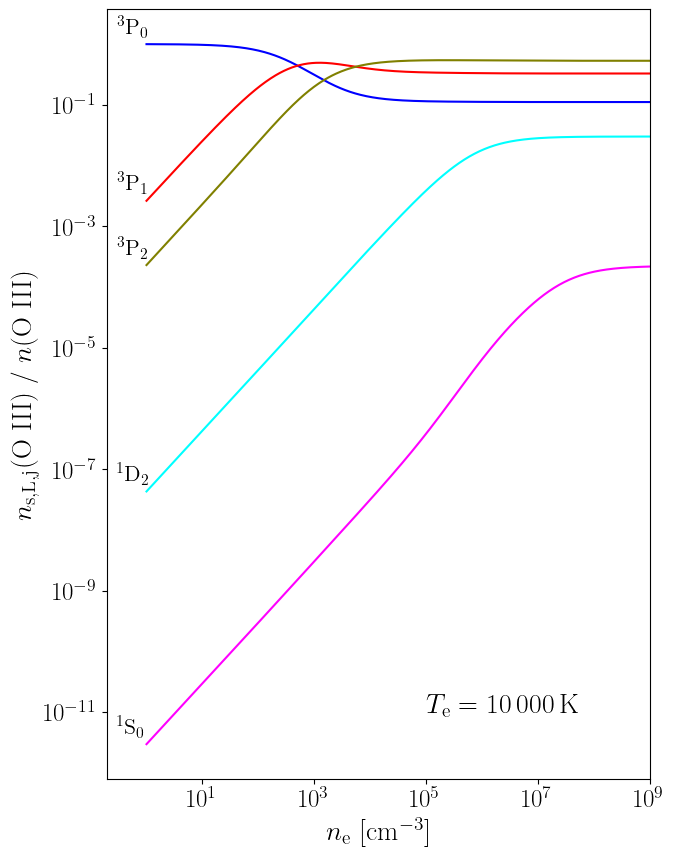

In [5]:
# Fijamos la temperatura electrónica:
T_e = 1e4 

# Creamos un array con valores del logaritmo de la densidad electrónica (entre 1 y 10^9 cm^-3):
log_n_e = np.linspace(np.log10(1), np.log10(1e9), 500)

# Calculamos las poblaciones relativas. El resultado es una matriz 5 x n donde n es el número de puntos que hamos tomado (500):
log_poblaciones = np.log10(O3.getPopulations(tem=T_e, den=10**log_n_e))

# Creamos el plot:
fig, ax = plt.subplots(figsize=(7, 10))
colores = ["blue", "red", "olive", "cyan", "magenta"]
nombres = [r"$^3$P$_0$", r"$^3$P$_1$", r"$^3$P$_2$", r"$^1$D$_2$", r"$^1$S$_0$"]
for nivel in range(len(log_poblaciones[:,0])):
    ax.plot(10**log_n_e, 10**log_poblaciones[nivel,:], color=colores[nivel])
    ax.text(0.3,1.5*10**log_poblaciones[nivel,0], nombres[nivel], color="black")

ax.text(1e5,1e-11,r"$T_\mathrm{e}=\SI{10000}{\kelvin}$", fontsize=20)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.2,1e9)
ax.set_xlabel(r"$n_\mathrm{e}$ [$\unit{\per\centi\meter\cubed}$]", fontsize=20)
ax.set_ylabel(r"$n_\mathrm{s,L,j}$(O III) / $n$(O III)", fontsize=20)
ax.tick_params(axis='both', labelsize=18)
fig.tight_layout

fig.savefig(os.path.join(results_dir,"poblaciones_densidad.pdf"), bbox_inches='tight')


### Apartado c)

**Representar gráficamente la población relativa de los cinco niveles del OIII para valores de temperatura electrónica variando entre 5000 y 15000K y suponiendo una densidad electrónica de 100 cm^-3.**

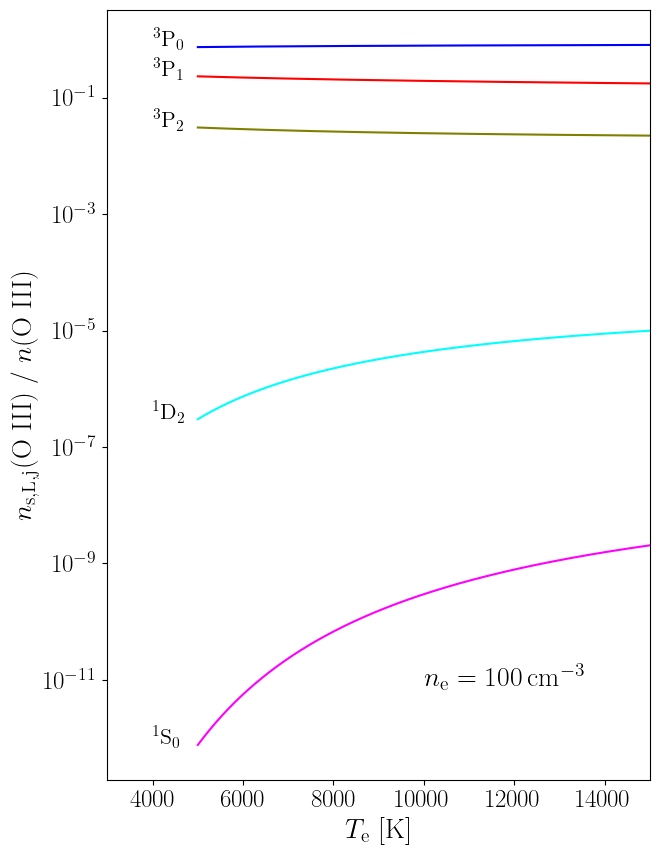

In [6]:
# Fijamos la densidad electrónica:
n_e = 100

# Creamos un array con valores de la temperatura electrónica (entre 5000 y 15000 K):
T_e = np.linspace(5000, 15000, 500)

# Calculamos las poblaciones relativas. El resultado es una matriz 5 x n donde n es el número de puntos que hamos tomado (500):
poblaciones = (O3.getPopulations(tem=T_e, den=n_e))

# Creamos el plot:
fig, ax = plt.subplots(figsize=(7, 10))
colores = ["blue", "red", "olive", "cyan", "magenta"]
nombres = [r"$^3$P$_0$", r"$^3$P$_1$", r"$^3$P$_2$", r"$^1$D$_2$", r"$^1$S$_0$"]
for nivel in range(len(log_poblaciones[:,0])):
    ax.plot(T_e, poblaciones[nivel,:], color=colores[nivel])
    ax.text(4000,poblaciones[nivel,0], nombres[nivel], color="black")

ax.text(1e4,8e-12,r"$n_\mathrm{e}=\SI{100}{\per\centi\meter\cubed}$", fontsize=20)
ax.set_yscale("log")
ax.set_xlim(3000,15000)
ax.set_xlabel(r"$T_\mathrm{e}$ [$\unit{\kelvin}$]", fontsize=20)
ax.set_ylabel(r"$n_\mathrm{s,L,j}$(O III) / $n$(O III)", fontsize=20)
ax.tick_params(axis='both', labelsize=18)
fig.tight_layout

fig.savefig(os.path.join(results_dir,"poblaciones_temperatura.pdf"), bbox_inches='tight')

### Apartado d)

**Representar gráficamente el cociente de las emisividades, j, de las líneas [OIII] 5007 Å y [OIII] 4363 Å respecto a la temperatura electrónica (entre 5000 y 15000K) suponiendo una densidad de 100, 105 y 109 cm^-3.**

Input wave: 5007.0
Closest wave found: 5006.8
Relative error: 3E-05 
Transition: 4 -> 3

Input wave: 4363.0
Closest wave found: 4363.2
Relative error: -5E-05 
Transition: 5 -> 4


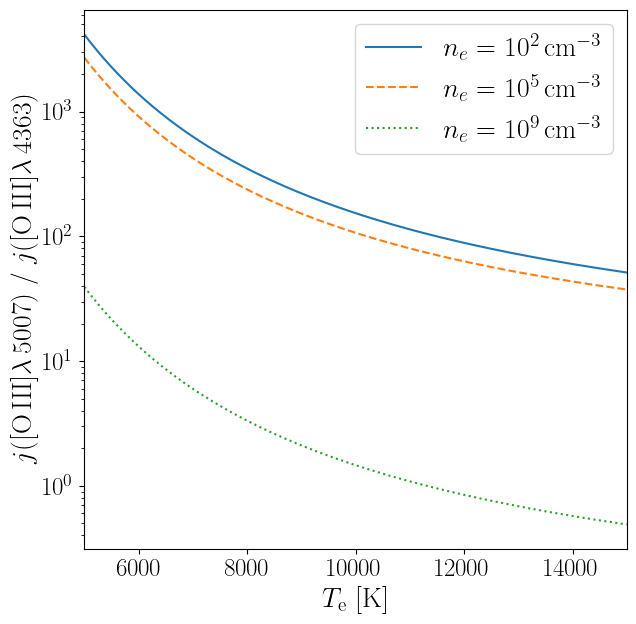

In [7]:
# Creamos un array con valores de la temperatura electrónica (entre 5000 y 15000 K):
T_e = np.linspace(5000, 15000, 500) # kelvin

# Creamos un array con valores de la densidad electrónica (100, 1e5, 1e9) cm^-3
n_e = np.array([100, 1e5, 1e9])

# Información sobre las transiciones:
O3.printTransition(5007)
print("")
O3.printTransition(4363)

# Emisividad de la linea de 5007 A (matriz 500 x 3):
j_5007 = O3.getEmissivity(tem=T_e, den=n_e, wave=5007) # en erg s^-1 cm^-3
# Emisividad de la linea de 4363 A (matriz 500 x 3):
j_4363 = O3.getEmissivity(tem=T_e, den=n_e, wave=4363) # en erg s^-1 cm^-3

# Cociente de las lineas (matriz 500 x 3):
j_ratio = j_5007/j_4363
#print(j_ratio.shape)

# Creamos el plot:
fig, ax = plt.subplots(figsize=(7, 7))
colores = ["red", "blue", "green"]
estilos = ["solid", "dashed", "dotted"]
for i, dens in enumerate(n_e):
    ax.plot(T_e, j_ratio[:,i], label=rf"$n_e = 10^{{{int(np.log10(dens))}}}\,$"+ r"$\mathrm{cm^{-3}}$",
            linestyle=estilos[i])
    #ax.text(4000,poblaciones[nivel,0], nombres[nivel], color="black")

#ax.text(1e4,8e-12,r"$n_\mathrm{e}=\SI{100}{\per\centi\meter\cubed}$", fontsize=20)
ax.legend(loc="best", fontsize=20)
ax.set_yscale("log")
ax.set_xlim(5000,15000)
ax.set_xlabel(r"$T_\mathrm{e}$ [$\unit{\kelvin}$]", fontsize=20)
ax.set_ylabel(r"$j(\mathrm{[O\, III]}\lambda\,5007)$ / $j(\mathrm{[O\, III]}\lambda\,4363)$", fontsize=20)
ax.tick_params(axis='both', labelsize=18)
fig.tight_layout

fig.savefig(os.path.join(results_dir,"cociente_lineas.pdf"), bbox_inches='tight')
